Kullanılan Cihaz: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\edize/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


c:\Users\edize\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\edize\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100.0%



--- EfficientNet Eğitimi Başlıyor ---
Epoch 1/3
train Loss: 0.0152 Acc: 0.9951
test Loss: 0.0069 Acc: 0.9974
Epoch 2/3
train Loss: 0.0047 Acc: 0.9987
test Loss: 0.0016 Acc: 0.9995
Epoch 3/3
train Loss: 0.0056 Acc: 0.9986
test Loss: 0.0120 Acc: 0.9964

Eğitim Bitti. Süre: 500sn


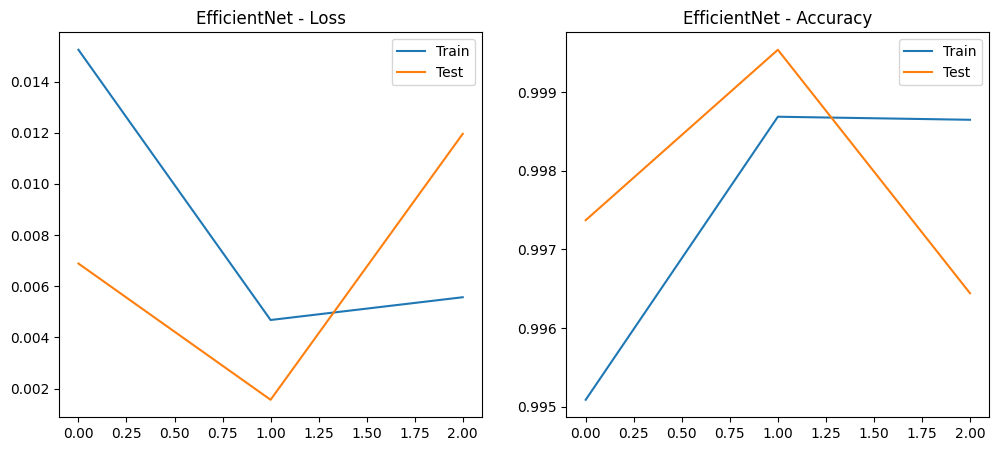

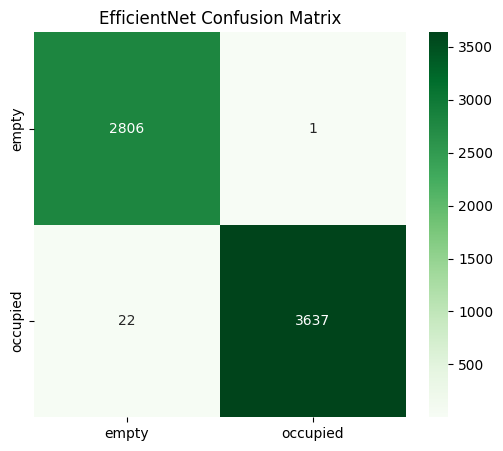

              precision    recall  f1-score   support

       empty     0.9922    0.9996    0.9959      2807
    occupied     0.9997    0.9940    0.9968      3659

    accuracy                         0.9964      6466
   macro avg     0.9960    0.9968    0.9964      6466
weighted avg     0.9965    0.9964    0.9964      6466



In [1]:
# ---------------------------------------------------------
# PROJE: Otopark Doluluk Tespiti (DeepPark)
# ÖĞRENCİ: Muhammet Emin Çapan - 23040301106
# MODEL: EfficientNet B0
# ---------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
import time

# --- AYARLAR (Rapora Uygun) ---
DATA_DIR = r"C:\Users\edize\Final_Dataset"  # BURAYI DEĞİŞTİR
IMG_SIZE = 224  # EfficientNet için standart
BATCH_SIZE = 32
LEARNING_RATE = 0.001  # EfficientNet için biraz daha yüksek LR
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

# --- VERİ HAZIRLAMA ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomRotation(10),  # Biraz veri artırma
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# --- MODEL (EfficientNet B0) ---
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 Sınıf
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- EĞİTİM ---
train_loss, train_acc = [], []
val_loss, val_acc = [], []

print("\n--- EfficientNet Eğitimi Başlıyor ---")
start_time = time.time()

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    
    for phase in ['train', 'test']:
        if phase == 'train': model.train()
        else: model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc.item())
        else:
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc.item())
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print(f'\nEğitim Bitti. Süre: {(time.time() - start_time):.0f}sn')

# --- GRAFİKLER ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Test')
plt.title('EfficientNet - Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Test')
plt.title('EfficientNet - Accuracy')
plt.legend()
plt.savefig('EfficientNet_Egitim_Grafigi.png')
plt.show()

# --- CONFUSION MATRIX ---
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNet Confusion Matrix')
plt.savefig('EfficientNet_Confusion_Matrix.png')
plt.show()

# DETAYLI RAPOR
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))